In [75]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [76]:
import sys
sys.path.append(r'../')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [77]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/repartrition_01-03/'               # Harmon server
name_project

'project_repartrition/output_repar_01-02/'

In [78]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  
dir_project_workspace:  
dir_project:  project_repartrition/output_repar_01-02/


In [79]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [80]:
name_project_probes = info_basic['name_project_probes']
name_project_regions = info_basic['name_project_regions']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_regions = os.path.join(dir_project_workspace, name_project_regions)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_regions: ', dir_project_regions)

dir_project_probes:  project/output_FJSJ_17-01/
dir_project_regions:  project/output_FJSJ_17-02/


In [81]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_regions+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_regions = yaml.load(f.read(), Loader=yaml.FullLoader)

In [82]:
probes = info_basic_probes['key_subworks']
key_subworks = info_basic_regions['key_subworks']

In [83]:
dir_image = dir_project+info_basic['dir_image']
dir_disp  = dir_project + info_basic['dir_disp'] 

### Pick probes' Phase velocity automatically

In [84]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [85]:
def pick_velocity(key_subwork):
    global f
    global c
    global info_basic
    global info_basic_probes
    global info_basic_regions
    global flag_f
    global flag_c
    global dir_project
    global dir_peoject_probes
    global dir_disp

    grace = 0.02

    dir_ds_probes = dir_project_probes + info_basic_probes['dir_ds']
    ds = h5py.File(dir_ds_probes+'ds_'+key_subwork+'.h5', 'r')

    ds_remove = ds['ds_remove'][0]
    f_sample = []
    c_sample = []

    f_new = f[np.logical_and(f>flag_f[0],f < flag_f[1])]
    c_new = c[np.logical_and(c>flag_c[0],c < flag_c[1])]

    # Three samples
    f0 = flag_f[0]
    f1 = (flag_f[0] + flag_f[1])/3
    f2 = flag_f[1]
    c0 = c_new[np.argmax(ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),f==find_nearest(f,f0)])]
    c1 = c_new[np.argmax(ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),f==find_nearest(f,f1)])]
    c2 = c_new[np.argmax(ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),f==find_nearest(f,f2)])]

    ds_new0 = ds_remove[np.logical_and(c>flag_c[0],c < flag_c[1]),:]
    ds_new = ds_new0[:,np.logical_and(f>flag_f[0],f < flag_f[1])]   
    

    for index_f in range(len(f_new)):
        #print(index_f)
        if f_new[index_f] >= f0 and f_new[index_f] < f1:
            slope = (c1-c0)/(f1-f0)
            #index_c = np.where(ds_new[:,index_f] == np.max(ds_new[c_new<c0+slope*(f_new[index_f]-f0)+grace,index_f] ))[0][0]
            index_c = np.argmax(ds_new[c_new<c0+slope*(f_new[index_f]-f0)+grace,index_f])
        else:
            slope = (c2-c1)/(f2-f1)
            index_c = np.argmax(ds_new[c_new<c1+slope*(f_new[index_f]-f1)+grace,index_f])
            #index_c = np.where(ds_new[:,index_f] == np.max(ds_new[c_new[c_new<flag_c[1]*0.7]<c1+slope*(f_new[index_f]-f1)+grace,index_f] ))[0][0]
        f_sample.append(f_new[index_f])
        c_sample.append(c_new[index_c])

    f_smooth = np.linspace(min(f_sample), max(f_sample), 200)  # np.linspace 等差数列,从x.min()到x.max()生成300个数，便于后续插值
    c_smooth = make_interp_spline(f_sample, c_sample)(f_smooth)
    # 写入txt文件
    np.savetxt(dir_disp+'autopick_'+key_subwork+'.txt', np.array([f_smooth,c_smooth]).T, fmt='%.2f', delimiter=',')
    #return ds_remove, f_smooth, c_smooth,f0,f1,f2,c0,c1,c2


In [86]:
f = info_basic_bi_probes['f']
c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])

In [87]:
flag_c = [0.3,1.2]
flag_f = [8,18]
nThreads = 5
c_mean = {}
c_mean_data = np.zeros(len(f))
flag_pick = 0
flag_multiple = 1

In [88]:
if flag_pick == 1:
    for probe in probes:
        pick_velocity(probe)

### Plot to see pick results

In [89]:
def plot_disp(ax,key_subwork):
    global dir_disp_probes
    global dir_disp
    global f
    global c

    dir_ds_probes = dir_project_probes + info_basic_probes['dir_ds']
    ds = h5py.File(dir_ds_probes+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]

    title0 = key_subwork
    ax = plotlib.plot_fj(ax,ds_remove,title0,f,c,0,c_map='jet')

    f_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,0]
    c_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,1]
    ax.scatter(f_pick,c_pick,marker='o',s=10,color='k')


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for probe in probes[0:3]:
    print(probe)
    f_pick = np.loadtxt(dir_disp+'autopick_'+probe+'.txt',delimiter=',')[:,0]
    c_pick = np.loadtxt(dir_disp+'autopick_'+probe+'.txt',delimiter=',')[:,1]
    ax.scatter(f_pick,c_pick,marker='o',s=10)

In [90]:
"""
for probe in probes[0:3]:
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    plot_disp(ax,probe)
"""

'\nfor probe in probes[0:3]:\n    fig,ax = plt.subplots(1,1,figsize=(8,6))\n    plot_disp(ax,probe)\n'

### calculate K-S value to see the result

In [93]:
def loc_key(key_subwork):
    global stalist_all
    global lat_all
    global lon_all
    key = 'R'+key_subwork[0:2]+key_subwork[3:]
    if key in stalist_all:
        lat_this = lat_all[stalist_all.index(key)]
        lon_this = lon_all[stalist_all.index(key)]
    else:
        key1 = 'R' + str(int(key_subwork[0:2])-1).zfill(2)+key_subwork[3:5]
        key2 = 'R' + str(int(key_subwork[0:2])+1).zfill(2)+key_subwork[3:5]
        indx1 = stalist_all.index(key1)
        indx2 = stalist_all.index(key2)
        lat_this= (lat_all[indx1]+lat_all[indx2])/2
        lon_this = (lon_all[indx1]+lon_all[indx2])/2
    return lon_this,lat_this
    

In [94]:
def extract_probes(key_subwork):
    global dir_project
    global dir_project_probes
    global dir_project_regions
    global probes
    global stainfo_regions

    stas = stainfo_regions[key_subwork]['Station'].tolist()
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_regions[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [95]:
stalistname_all = info_basic_probes['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [96]:
stalistname = dir_project_probes+ info_basic_probes['stalistname']
stainfo_probes = pd.read_excel(stalistname,sheet_name=None)
stalistname = dir_project_regions+ info_basic_regions['stalistname']
stainfo_regions = pd.read_excel(stalistname,sheet_name=None)

In [97]:
key_subwork = key_subworks[10]

In [98]:
probes_this = extract_probes(key_subwork)
stations = set()
for probe in probes_this:
    stations_this = [station for station in stainfo_probes[probe]['Station'].tolist()]
    stations = stations.union(set(stations_this))
    
stations = list(stations)
lats = [lat_all[stalist_all.index(station)] for station in stations]
lons = [lon_all[stalist_all.index(station)] for station in stations]

In [99]:
lon_this = []
lat_this = []
for probe in probes_this:
    lon,lat = loc_key(probe)
    lon_this.append(lon)
    lat_this.append(lat)

(-116.59694834999999,
 -116.58567665000001,
 33.534672199722195,
 33.542851800013224)

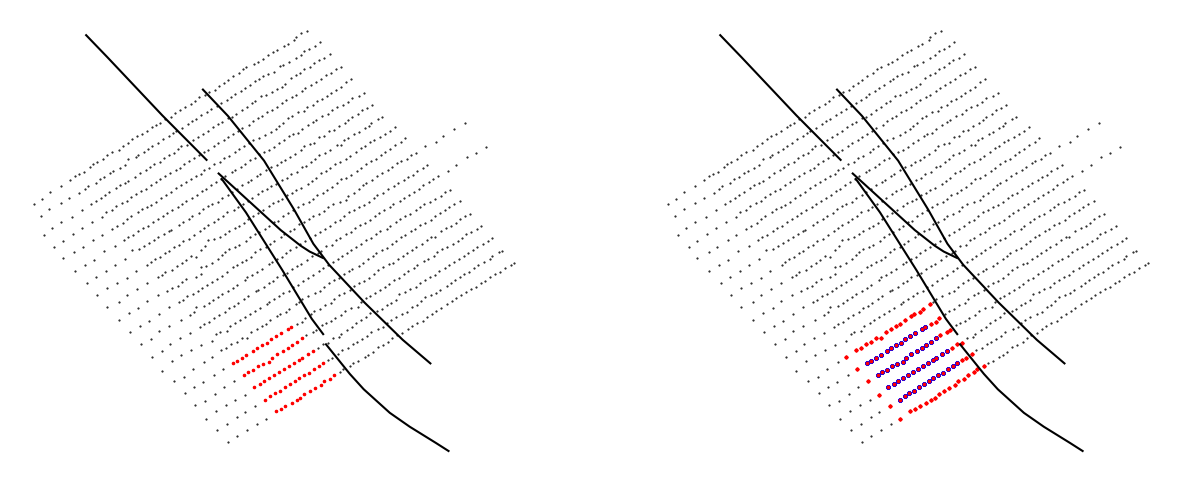

In [100]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
ax[0].scatter(stainfo_regions[key_subwork]['longitude'], stainfo_regions[key_subwork]['latitude'],marker='.',color='r',s=10)
ax[0].axis('off')

ax[1].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[1].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
    ax[1].scatter(lon_this, lat_this,marker='.',color='b',s=20)
    ax[1].scatter(lons,lats,marker='.',color='r',s=10)
ax[1].axis('off')

In [101]:
probes_this

['11-02',
 '12-02',
 '13-02',
 '14-02',
 '15-02',
 '16-02',
 '17-02',
 '18-02',
 '19-02',
 '20-02',
 '21-02',
 '22-02',
 '23-02',
 '11-03',
 '12-03',
 '13-03',
 '14-03',
 '15-03',
 '16-03',
 '17-03',
 '18-03',
 '19-03',
 '20-03',
 '21-03',
 '22-03',
 '23-03',
 '11-04',
 '12-04',
 '13-04',
 '14-04',
 '15-04',
 '16-04',
 '17-04',
 '18-04',
 '19-04',
 '20-04',
 '21-04',
 '22-04',
 '23-04',
 '11-05',
 '12-05',
 '13-05',
 '14-05',
 '15-05',
 '16-05',
 '17-05',
 '18-05',
 '19-05',
 '20-05',
 '21-05',
 '22-05',
 '23-05']

In [102]:
disp_all = {}
f_sample = np.array([])
for probe in probes_this:
    file_ds = dir_project  + info_basic['dir_disp'] + 'autopick_'+probe+'.txt'
    if f_sample.size == 0:
        f_sample = np.loadtxt(file_ds,delimiter=',')[:,0]
        c_all = np.zeros([len(probes_this),len(f_sample)])
    disp_all[probe] = np.loadtxt(file_ds,delimiter=',')[:,1]
    c_all[probes_this.index(probe)] = disp_all[probe]

### Use mean value to judge

In [103]:
# 计算平均值
c_mean = []
c_median = []
for i in range(len(f_sample)):
    data = c_all[:,i]
    mean_value = np.mean(data)
    std_dev = np.std(data)
    threshold = 2  # 根据需要调整阈值
    outliers = [value for value in data if abs(value - mean_value) > threshold * std_dev]
    # 移除异常值
    cleaned_data = [value for value in data if value not in outliers]
    # 计算修正后的平均值
    trimmed_mean = np.mean(cleaned_data)
    #median = np.median(data)
    c_mean.append(trimmed_mean)

(0.3, 1.2)

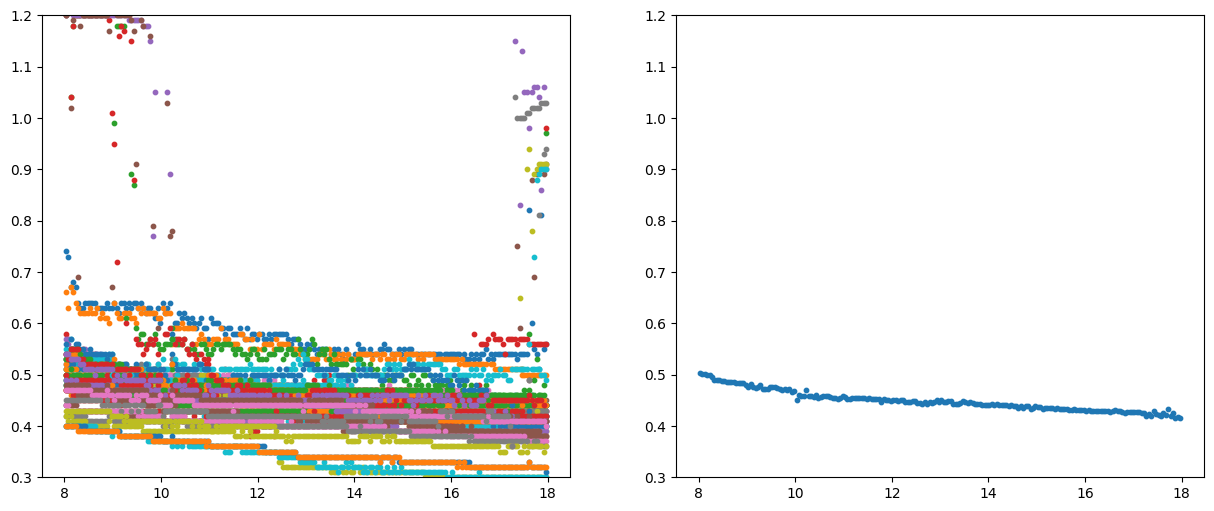

In [104]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
for probe in probes_this:
    ax[0].scatter(f_sample,disp_all[probe],marker='o',s=10)
ax[1].scatter(f_sample,c_mean,marker='o',s=10)
ax[0].set_ylim(flag_c)
ax[1].set_ylim(flag_c)

In [105]:
ks_p_values = []
ks_statistic = []
for probe in probes_this:
    ks_statistic.append(ks_2samp(disp_all[probe],c_mean)[0])
    ks_p_values.append(ks_2samp(disp_all[probe],c_mean)[1])

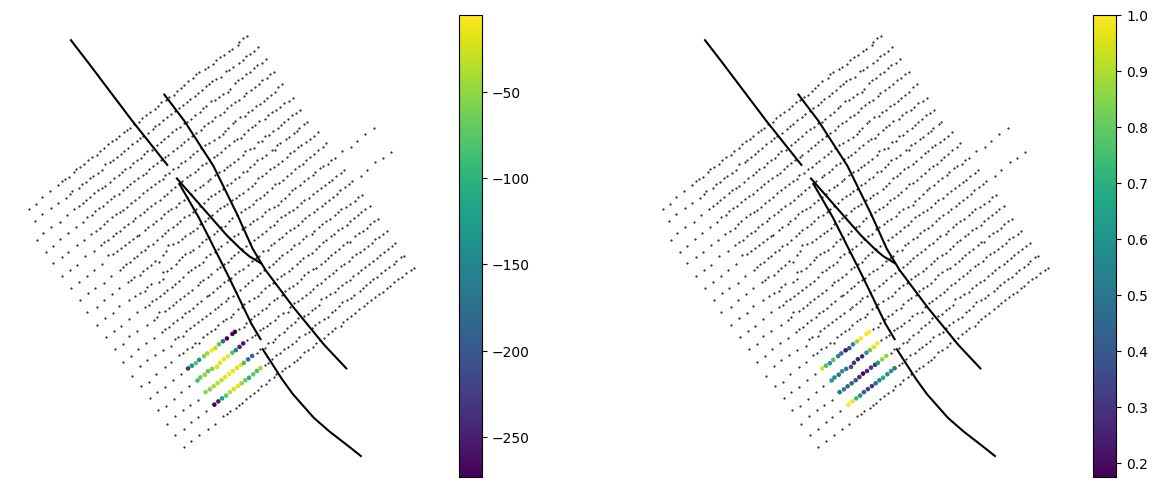

In [106]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
im=ax[0].scatter(lon_this, lat_this,marker='.',c=np.log(ks_p_values),s=20)
ax[0].axis('off')
plt.colorbar(im,ax=ax[0])

ax[1].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[1].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
im = ax[1].scatter(lon_this, lat_this,marker='.',c=ks_statistic,s=20)
ax[1].axis('off')
plt.colorbar(im,ax=ax[1])

In [107]:
flag_accept = 0.7
index_accept = np.array(ks_statistic)<flag_accept
probe_accept = np.array(probes_this)[index_accept]

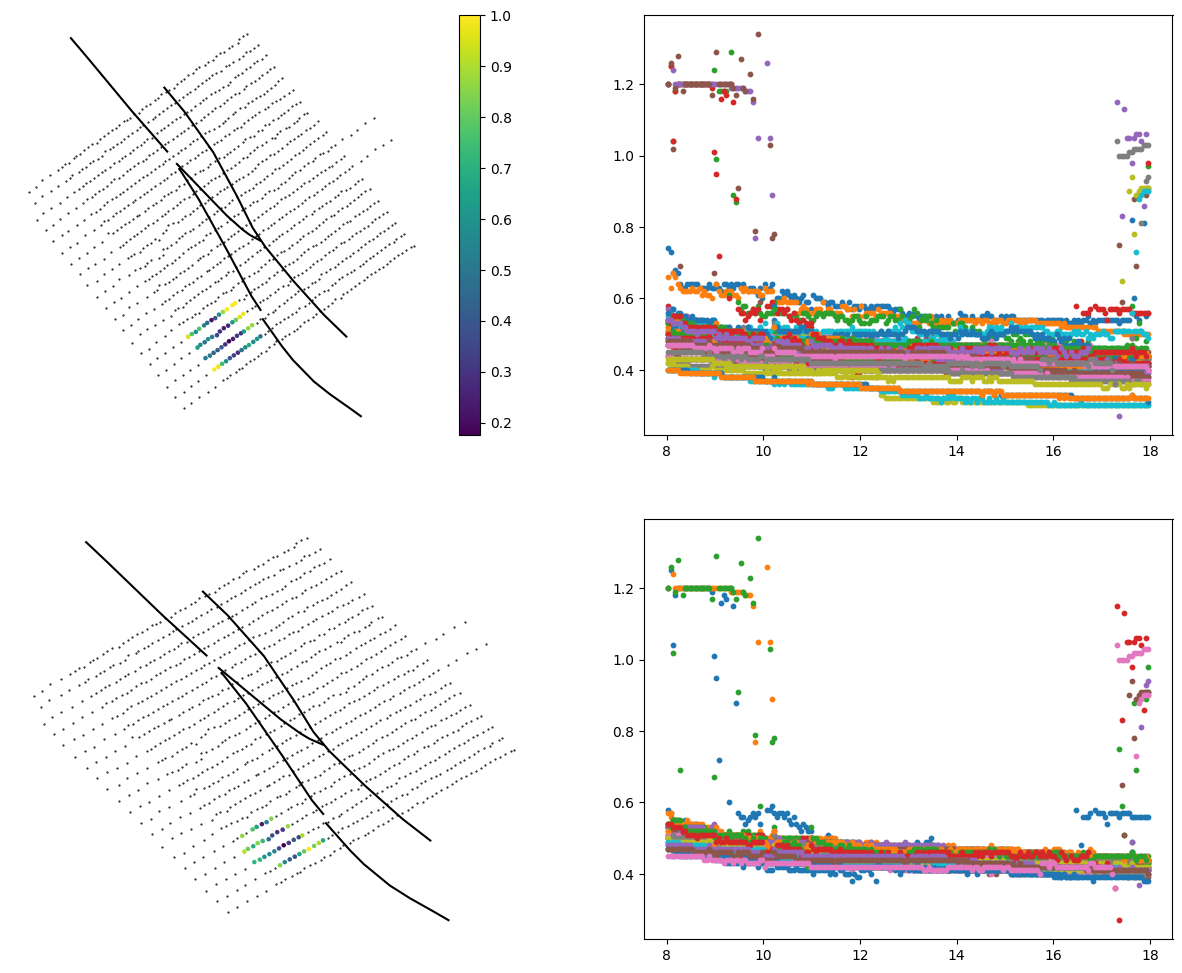

In [108]:
fig,ax = plt.subplots(2,2,figsize=(15,12))

ax[0][0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[0][0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
im = ax[0][0].scatter(lon_this, lat_this,marker='.',c=ks_statistic,s=20)
ax[0][0].axis('off')
plt.colorbar(im,ax=ax[0][0])

for probe in probes_this:
    ax[0][1].scatter(f_sample,disp_all[probe],marker='o',s=10)

ax[1][0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[1][0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
ax[1][0].scatter(np.array(lon_this)[index_accept], np.array(lat_this)[index_accept],marker='.',c=np.array(ks_statistic)[index_accept],s=20)
ax[1][0].axis('off')

for probe in probe_accept:
    ax[1][1].scatter(f_sample,disp_all[probe],marker='o',s=10)